In [135]:
import json
import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import requests
import scienceplots

from utils.config import data_path, header

In [136]:
plt.style.use('science')

In [137]:
# data statistics
raw_data_path = os.path.join(data_path, 'raw')
# list dir, only keep directories
slugs = [d for d in os.listdir(raw_data_path) if os.path.isdir(os.path.join(raw_data_path, d))]
print(f'number of projects: {len(slugs)}')

number of projects: 95


In [138]:
data_stats = []

for slug in slugs:
    has_description = os.path.exists(os.path.join(
        raw_data_path, slug, 'description.txt'))
    has_image = os.path.exists(os.path.join(raw_data_path, slug, 'image.png'))
    has_time_series = os.path.exists(os.path.join(
        raw_data_path, slug, 'time_series.json'))
    data_stats.append(dict(
        has_description=has_description,
        has_image=has_image,
        has_time_series=has_time_series,
        slug=slug
    ))

data_stats_df = pd.DataFrame(data_stats)
data_stats = data_stats_df.sum()
data_stats

has_description                                                   95
has_image                                                         95
has_time_series                                                   95
slug               meridian-art-blocks-playgroundcyberkongz-babie...
dtype: object

# Statistics for Single Collection

In [139]:
slug = 'fluf-world'

In [140]:
url = 'https://api-bff.nftpricefloor.com/projects/cryptopunks/sales-activity?count=300&order=desc'

In [141]:
response = requests.get(url, headers=header)

In [142]:
response_json = response.json()

In [143]:
len(response_json['activity'])

150

In [144]:
sales_activity = []
for item in response_json['activity']:
    eth_price = item['ethPrice']
    timestamp = item['timestamp'] / 1000000
    # convert to yyyy-mm-dd
    timestamp_text = pd.to_datetime(timestamp, unit='s').strftime('%Y-%m-%d')
    sales_activity.append(dict(
        eth_price=eth_price,
        timestamp_text=timestamp_text,
        timestamps=timestamp
    ))
sales_activity_df = pd.DataFrame(sales_activity)

In [145]:
sales_activity_df

,eth_price,timestamp_text,timestamps
0,46.51,2023-04-21,1.682089e+09
1,47.00,2023-04-21,1.682088e+09
2,47.25,2023-04-21,1.682088e+09
3,47.37,2023-04-21,1.682088e+09
4,47.41,2023-04-21,1.682088e+09
...,...,...,...
145,50.90,2023-04-19,1.681900e+09
146,50.90,2023-04-19,1.681900e+09
147,50.90,2023-04-19,1.681899e+09
148,50.90,2023-04-19,1.681898e+09


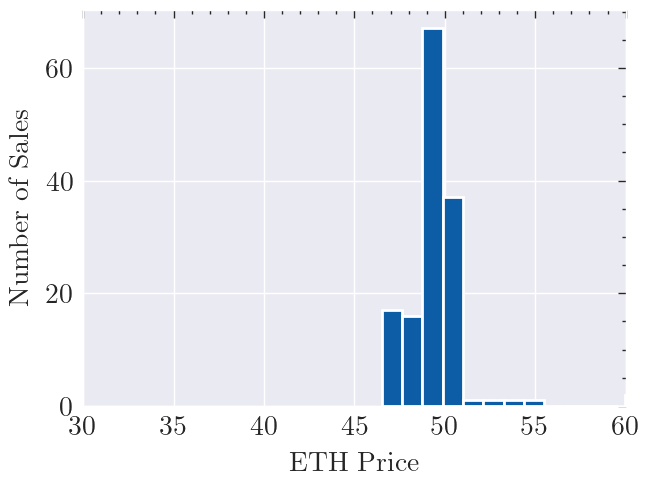

In [146]:
# plot the eth_price as histogram
fig, ax = plt.subplots()
fig.set_dpi(200)
ax.hist(sales_activity_df['eth_price'], bins=150)
ax.set_xlabel('ETH Price')
ax.set_ylabel('Number of Sales')
# set the x axis range to 0-100
ax.set_xlim(30, 60)

plt.savefig('eth_price_histogram.png', dpi=200)

plt.show()

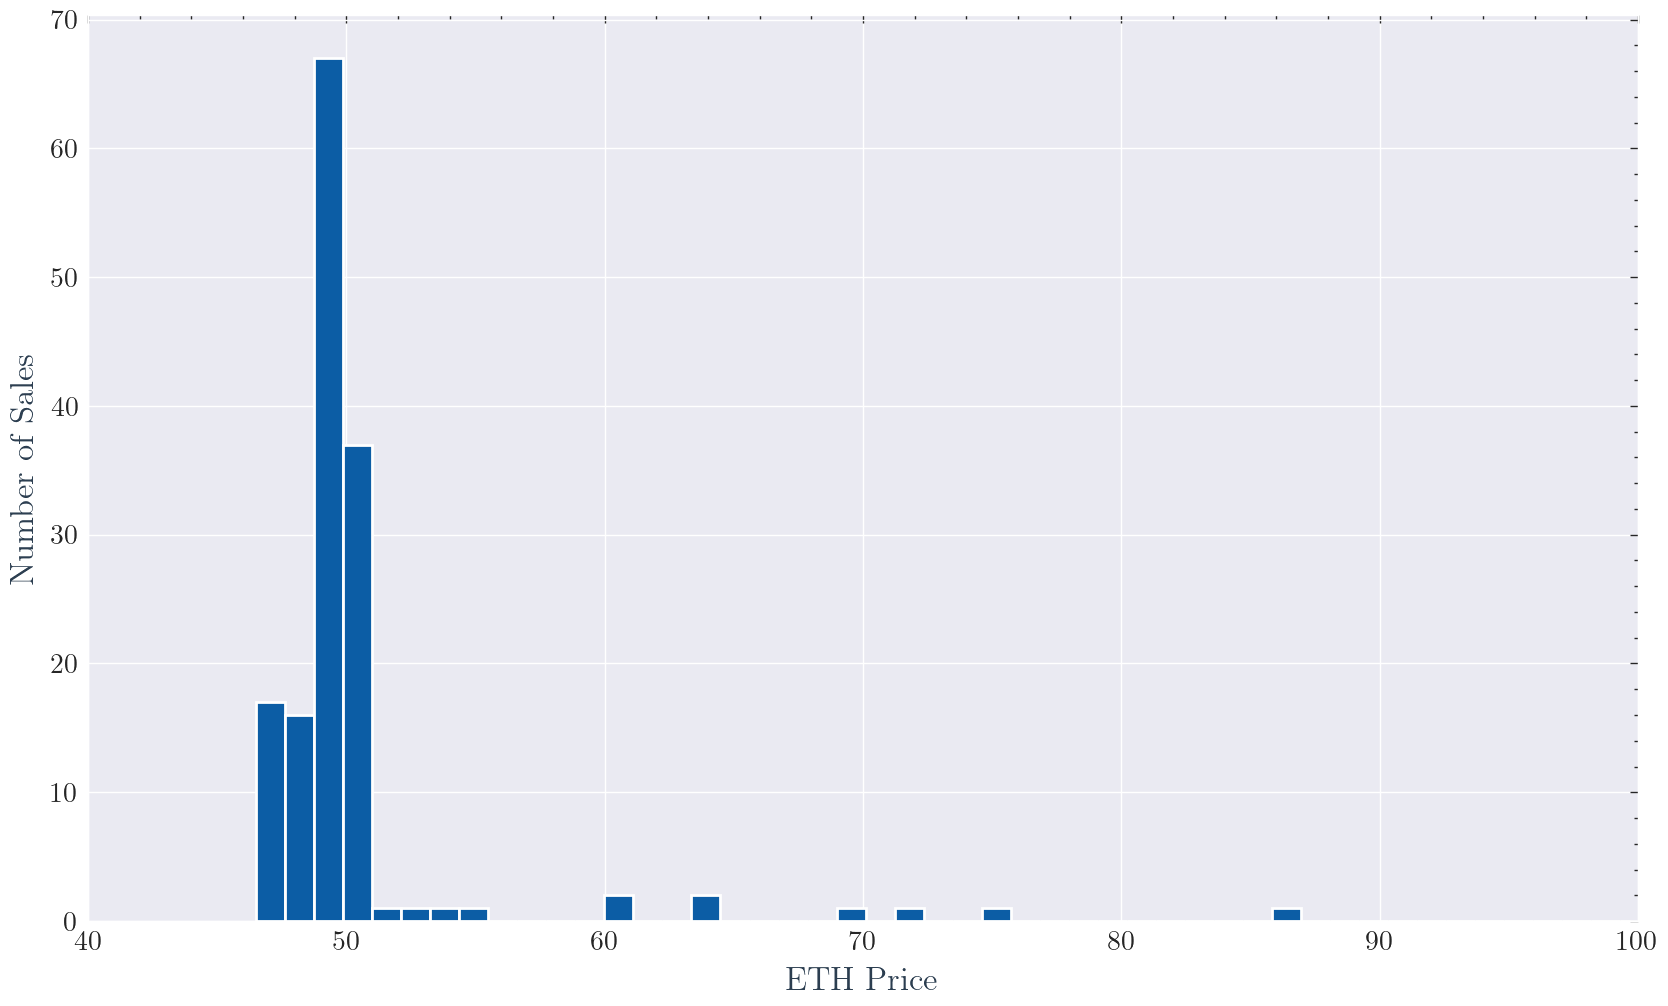

In [147]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Set the dpi of the figure
fig.set_dpi(200)

# Plot the histogram with customizations
ax.hist(sales_activity_df['eth_price'], bins=150)

# Set the x and y labels with customizations
ax.set_xlabel('ETH Price', fontsize=12, fontweight='bold', color='#2C3E50')
ax.set_ylabel('Number of Sales', fontsize=12, fontweight='bold', color='#2C3E50')

# Set the x and y tick labels with customizations
# ax.tick_params(axis='both', labelsize=10, colors='#2C3E50')

# Set the x and y limits with customizations
ax.set_xlim(40, 100)

# Set the title with customizations
# ax.set_title('Distribution of ETH Prices for Sales', fontsize=14, fontweight='bold', color='#2C3E50')

# Show the plot
plt.savefig('eth_price_histogram.png', dpi=200)

plt.show()

# Other Data Visualization

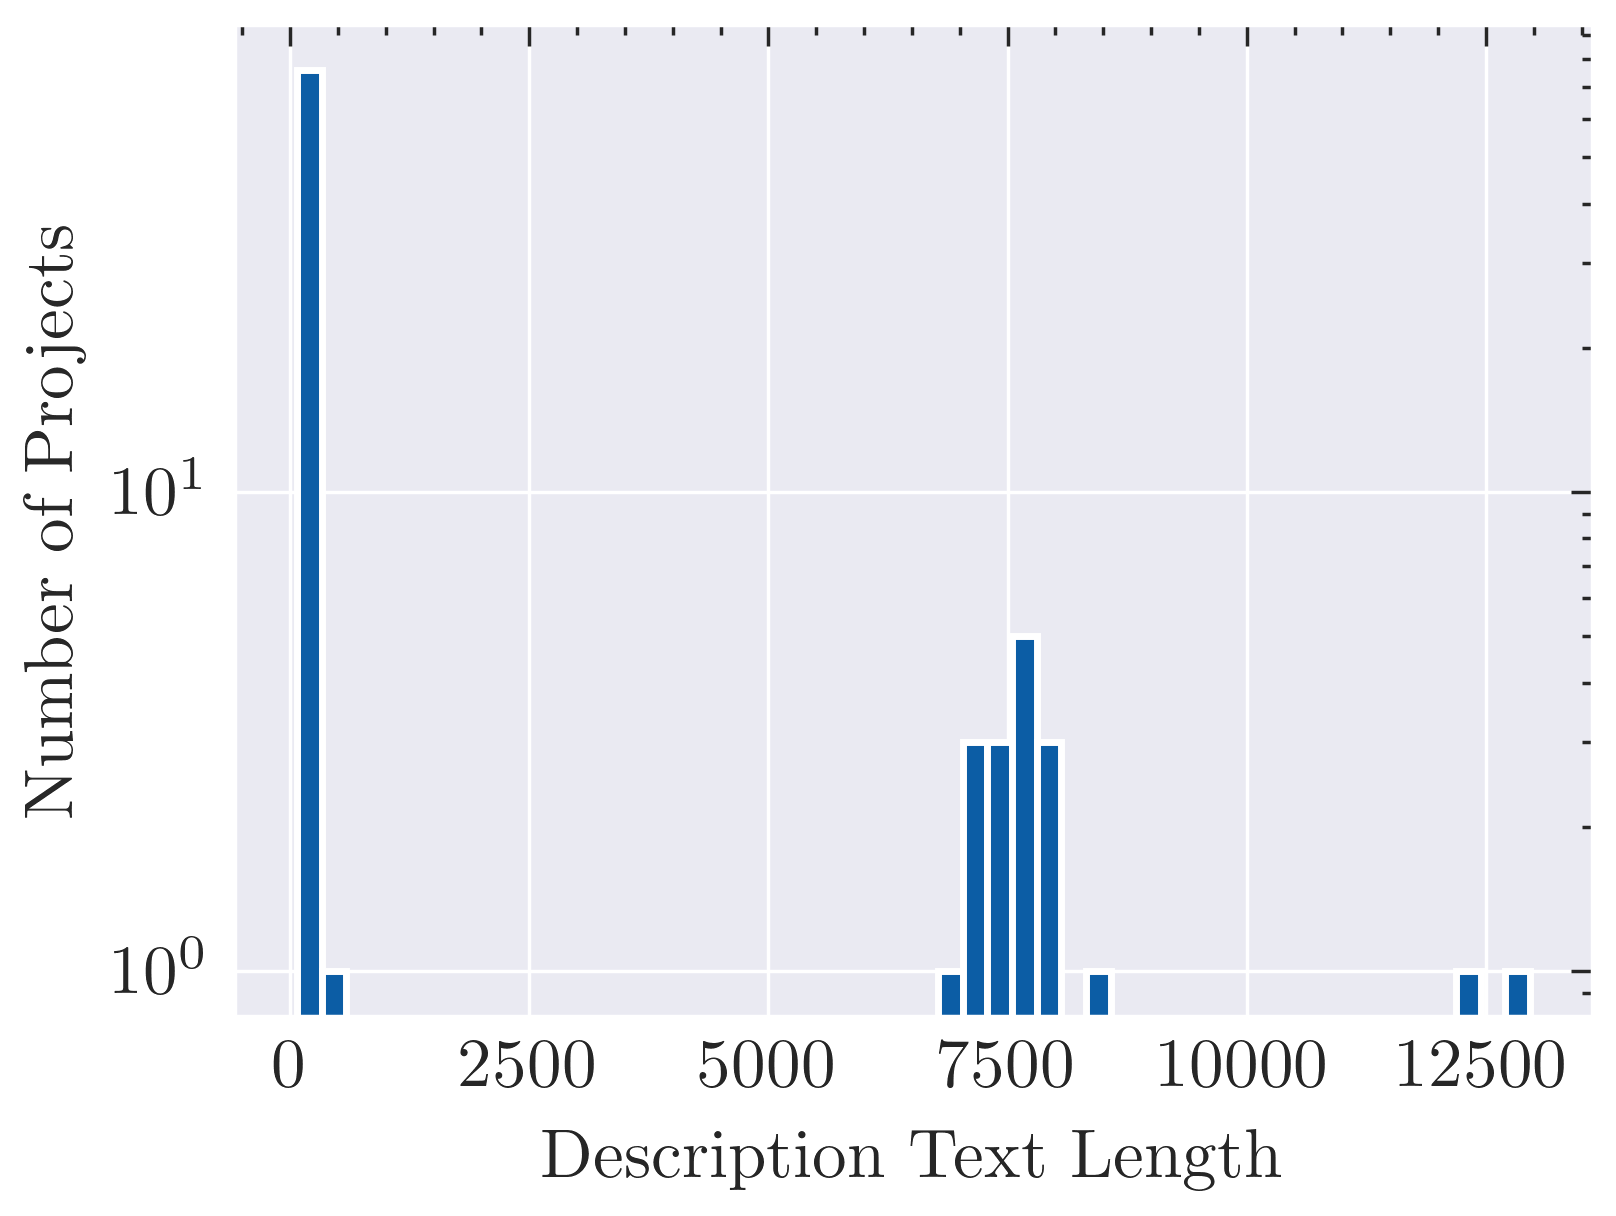

In [148]:
# compute description text length distribution then plot it
description_text_lengths = []
for slug in slugs:
    description_path = os.path.join(raw_data_path, slug, 'description.txt')
    if os.path.exists(description_path):
        with open(description_path, 'r') as f:
            description = f.read()
            description_text_lengths.append(len(description))

fig, ax = plt.subplots()
fig.set_dpi(500)
ax.hist(description_text_lengths, bins=50)
ax.set_xlabel('Description Text Length')
ax.set_ylabel('Number of Projects')
# set log
ax.set_yscale('log')

plt.savefig('description_text_length_histogram.png', dpi=500)

plt.show()

In [149]:
# compute statistics of description text length using pandas
description_text_lengths = []
for slug in slugs:
    description_path = os.path.join(raw_data_path, slug, 'description.txt')
    if os.path.exists(description_path):
        with open(description_path, 'r') as f:
            description = f.read()
            description_text_lengths.append(len(description))
description_text_lengths_df = pd.DataFrame(description_text_lengths, columns=['description_text_length'])
description_text_lengths_df.describe()

,description_text_length
count,95.000000
mean,1718.852632
std,3206.312344
min,72.000000
25%,215.000000
50%,234.000000
75%,301.000000
max,12960.000000


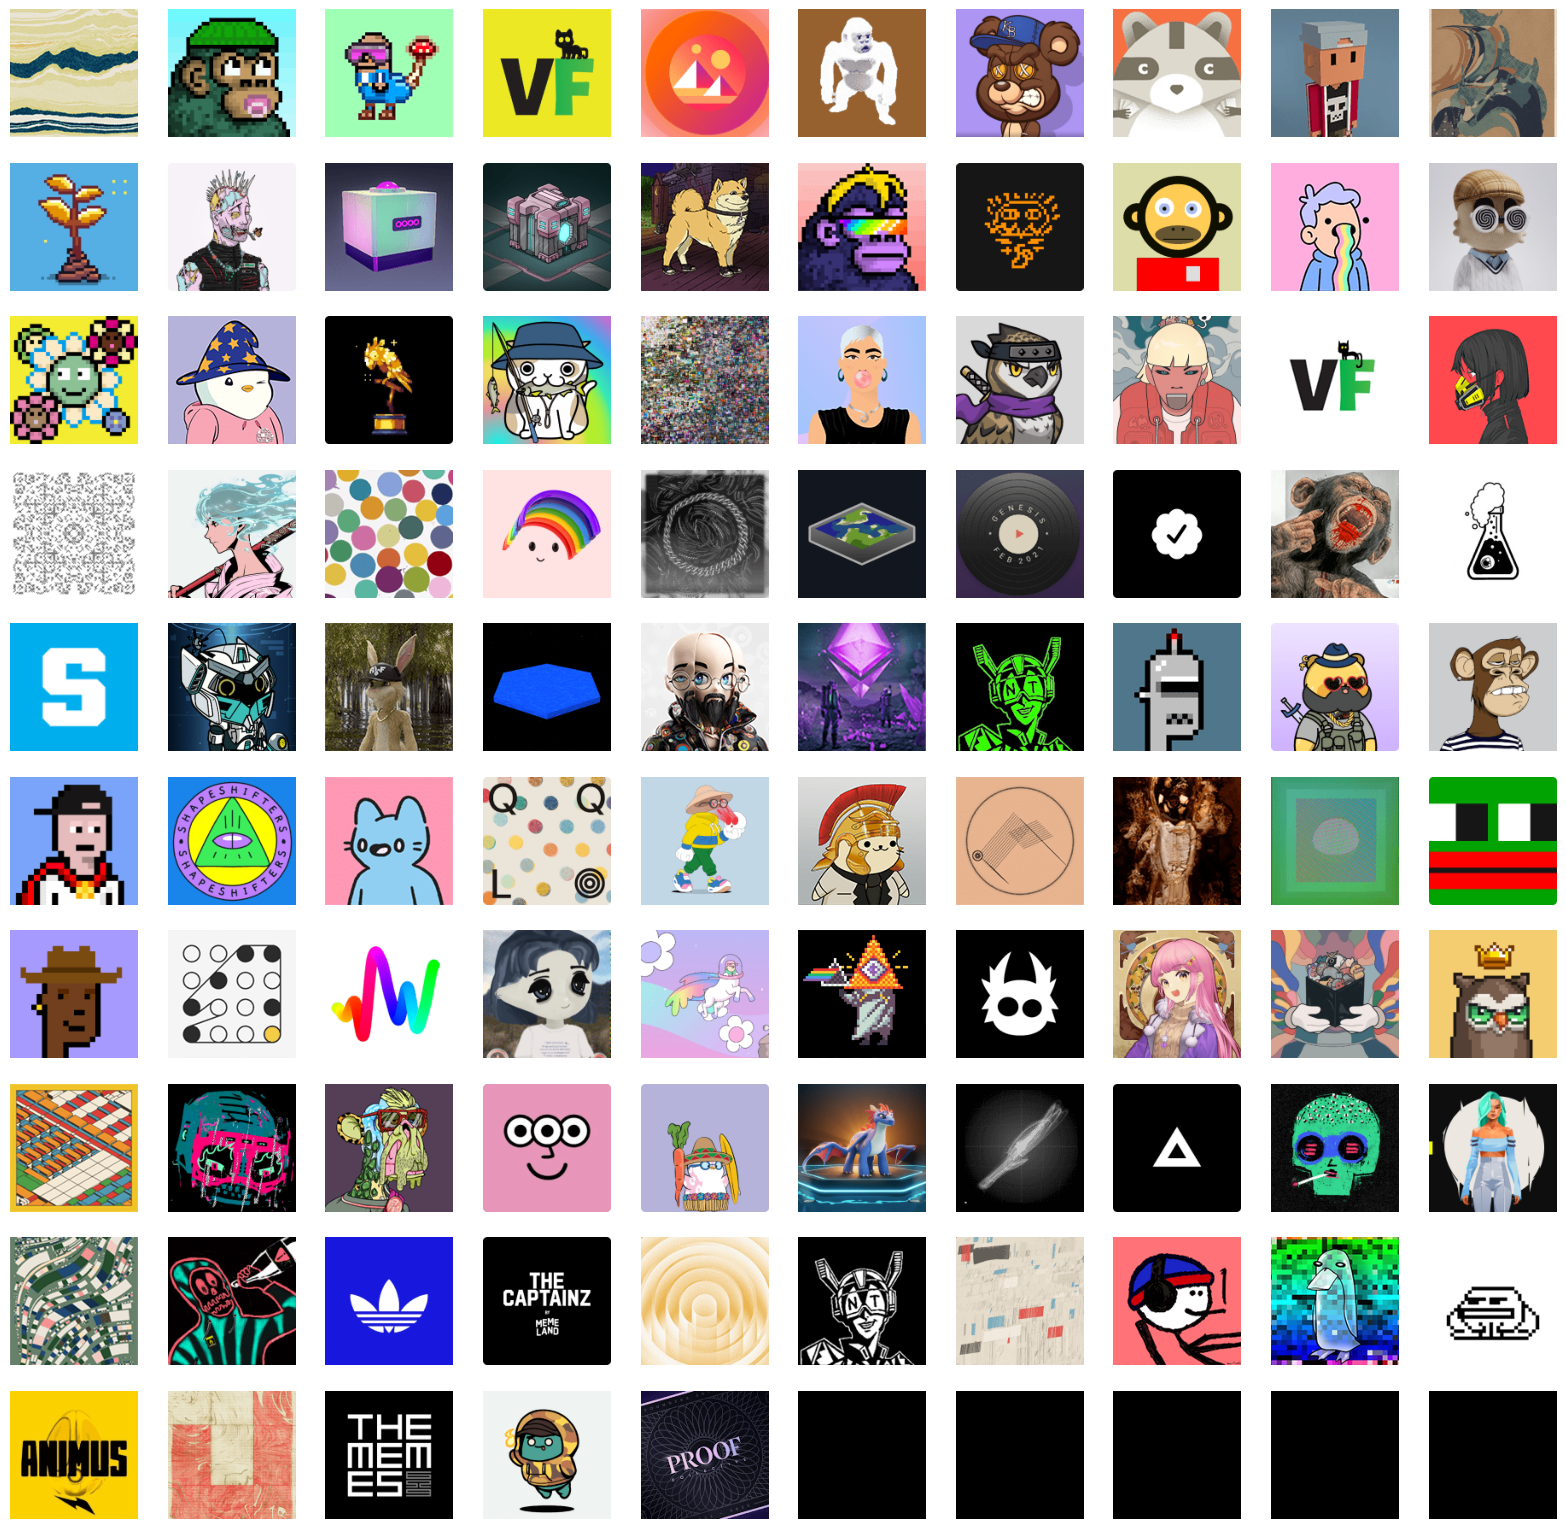

In [150]:
# visualize the project images as 10 * 10 grid; remove axis; for empty images, generate a black image
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.set_dpi(200)
for i, ax in enumerate(axes.flatten()):
    try:
        slug = slugs[i]
    except:
        ax.imshow(np.zeros((256, 256, 3)))
        ax.axis('off')
        continue
    image_path = os.path.join(raw_data_path, slug, 'image.png')
    if os.path.exists(image_path):
        image = plt.imread(image_path)
        ax.imshow(image)
    else:
        ax.imshow(np.zeros((256, 256, 3)))
    ax.axis('off')
    
plt.savefig('project_images.png', dpi=200)

plt.show()

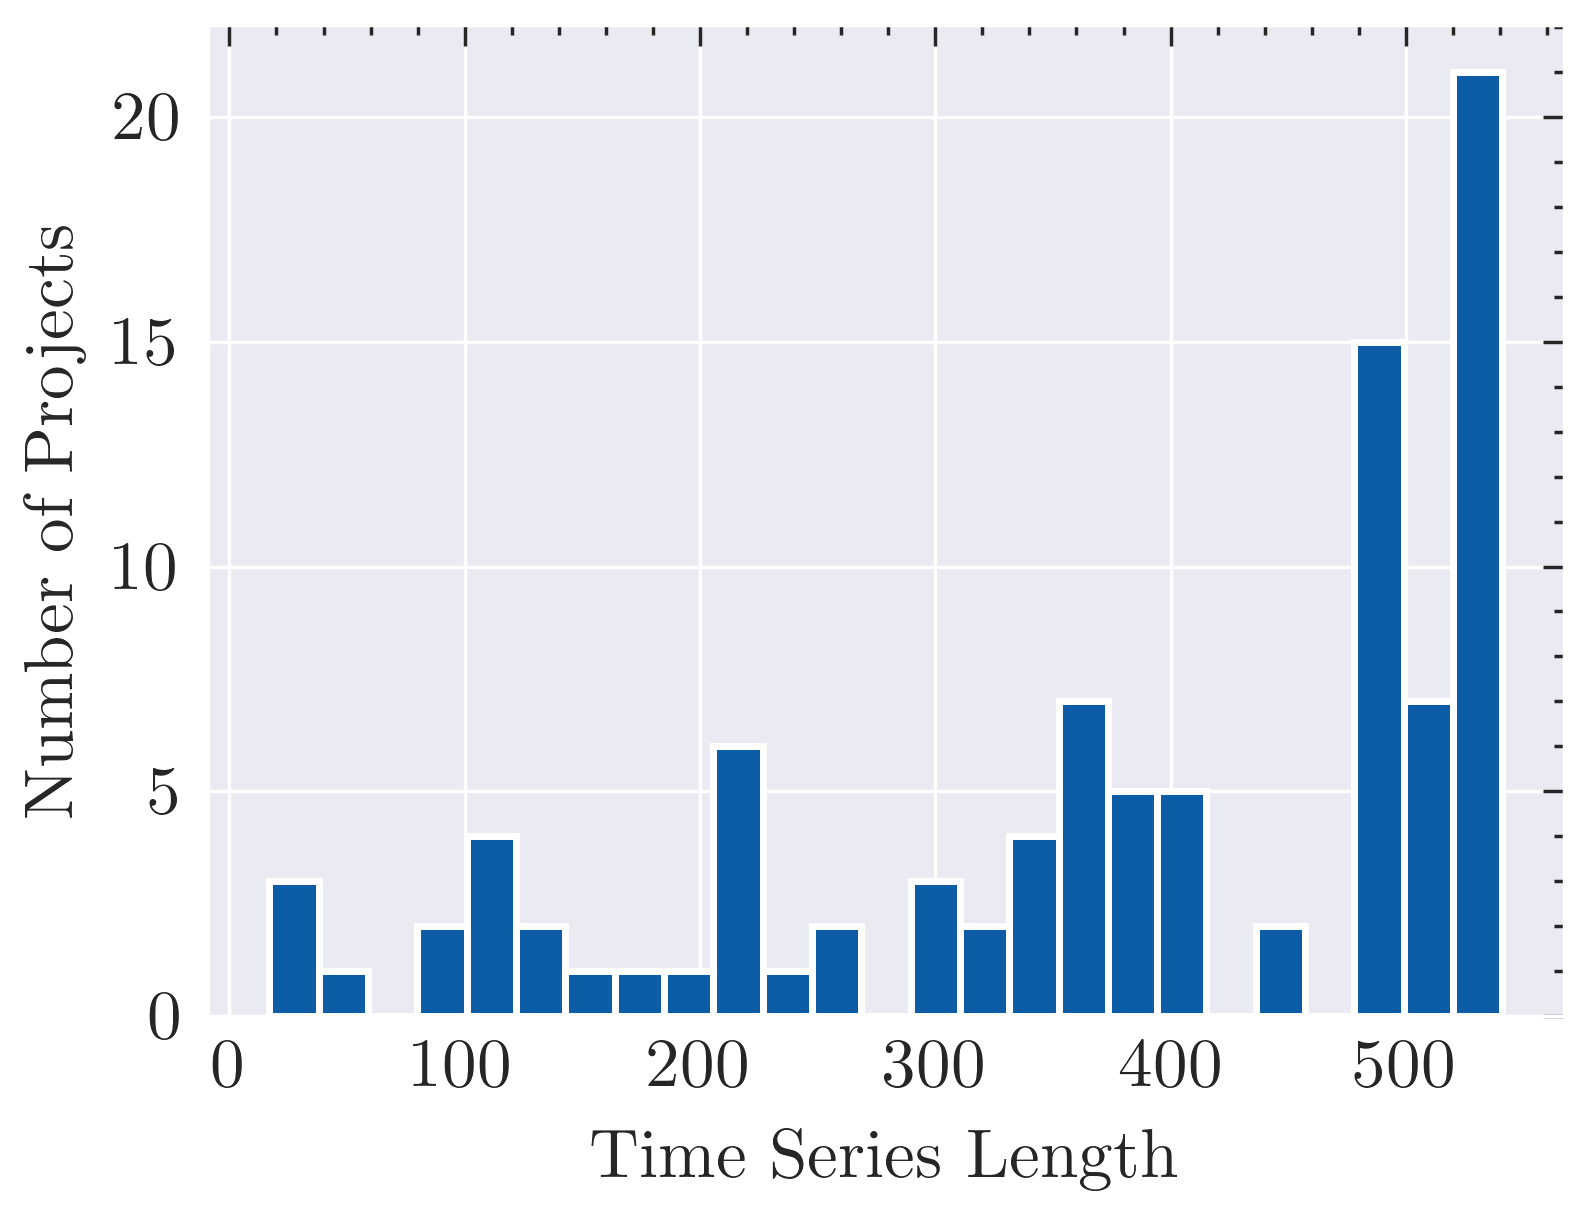

In [151]:
# visualize the distribution of time series length. Plot the histogram and density curve
time_series_lengths = []
for slug in slugs:
    time_series_path = os.path.join(raw_data_path, slug, 'time_series.json')
    if os.path.exists(time_series_path):
        with open(time_series_path, 'r') as f:
            time_series = json.load(f)
            time_series_lengths.append(len(pd.DataFrame(time_series)))

fig, ax = plt.subplots()
fig.set_dpi(500)
ax.hist(time_series_lengths, bins=25)

ax.set_xlabel('Time Series Length')
ax.set_ylabel('Number of Projects')

plt.savefig('time_series_length_histogram.png', dpi=500)

plt.show()

In [152]:
# calculate statistics for time series length, generate latex table
time_series_lengths = []
for slug in slugs:
    time_series_path = os.path.join(raw_data_path, slug, 'time_series.json')
    if os.path.exists(time_series_path):
        with open(time_series_path, 'r') as f:
            time_series = json.load(f)
            time_series_lengths.append(len(pd.DataFrame(time_series)))

time_series_lengths = pd.DataFrame(time_series_lengths)
time_series_lengths.describe()

,0
count,95.000000
mean,380.157895
std,156.589062
min,17.000000
25%,276.000000
50%,410.000000
75%,508.500000
max,541.000000


In [153]:
time_series_df 

,slug,granularity,floorEth,floorUsd,salesCount,volumeEth,volumeUsd
timestamps,,,,,,,
2021-10-25 00:00:00.000000000,cryptopunks,1d,94.95000,395801.923500,9,1017.690000,4.242271e+06
2021-10-26 00:00:00.000000000,cryptopunks,1d,90.95000,371266.085500,11,1327.150000,5.417546e+06
2021-10-27 00:00:00.000000000,cryptopunks,1d,96.00000,405231.360000,9,1581.750000,6.676820e+06
2021-10-28 00:00:00.000000000,cryptopunks,1d,94.95000,392351.440500,10,1599.360000,6.608859e+06
2021-10-29 00:00:00.000000000,cryptopunks,1d,94.99000,372860.447400,14,125922.107525,4.942770e+08
...,...,...,...,...,...,...,...
2023-04-14 00:00:00.000000000,cryptopunks,1d,54.82000,105266.626560,136,7680.818360,1.476703e+07
2023-04-15 00:00:00.000000000,cryptopunks,1d,53.00000,103019.965610,105,5762.560000,1.140246e+07
2023-04-16 00:00:00.000000000,cryptopunks,1d,52.80000,107462.613310,14,760.609000,1.580973e+06


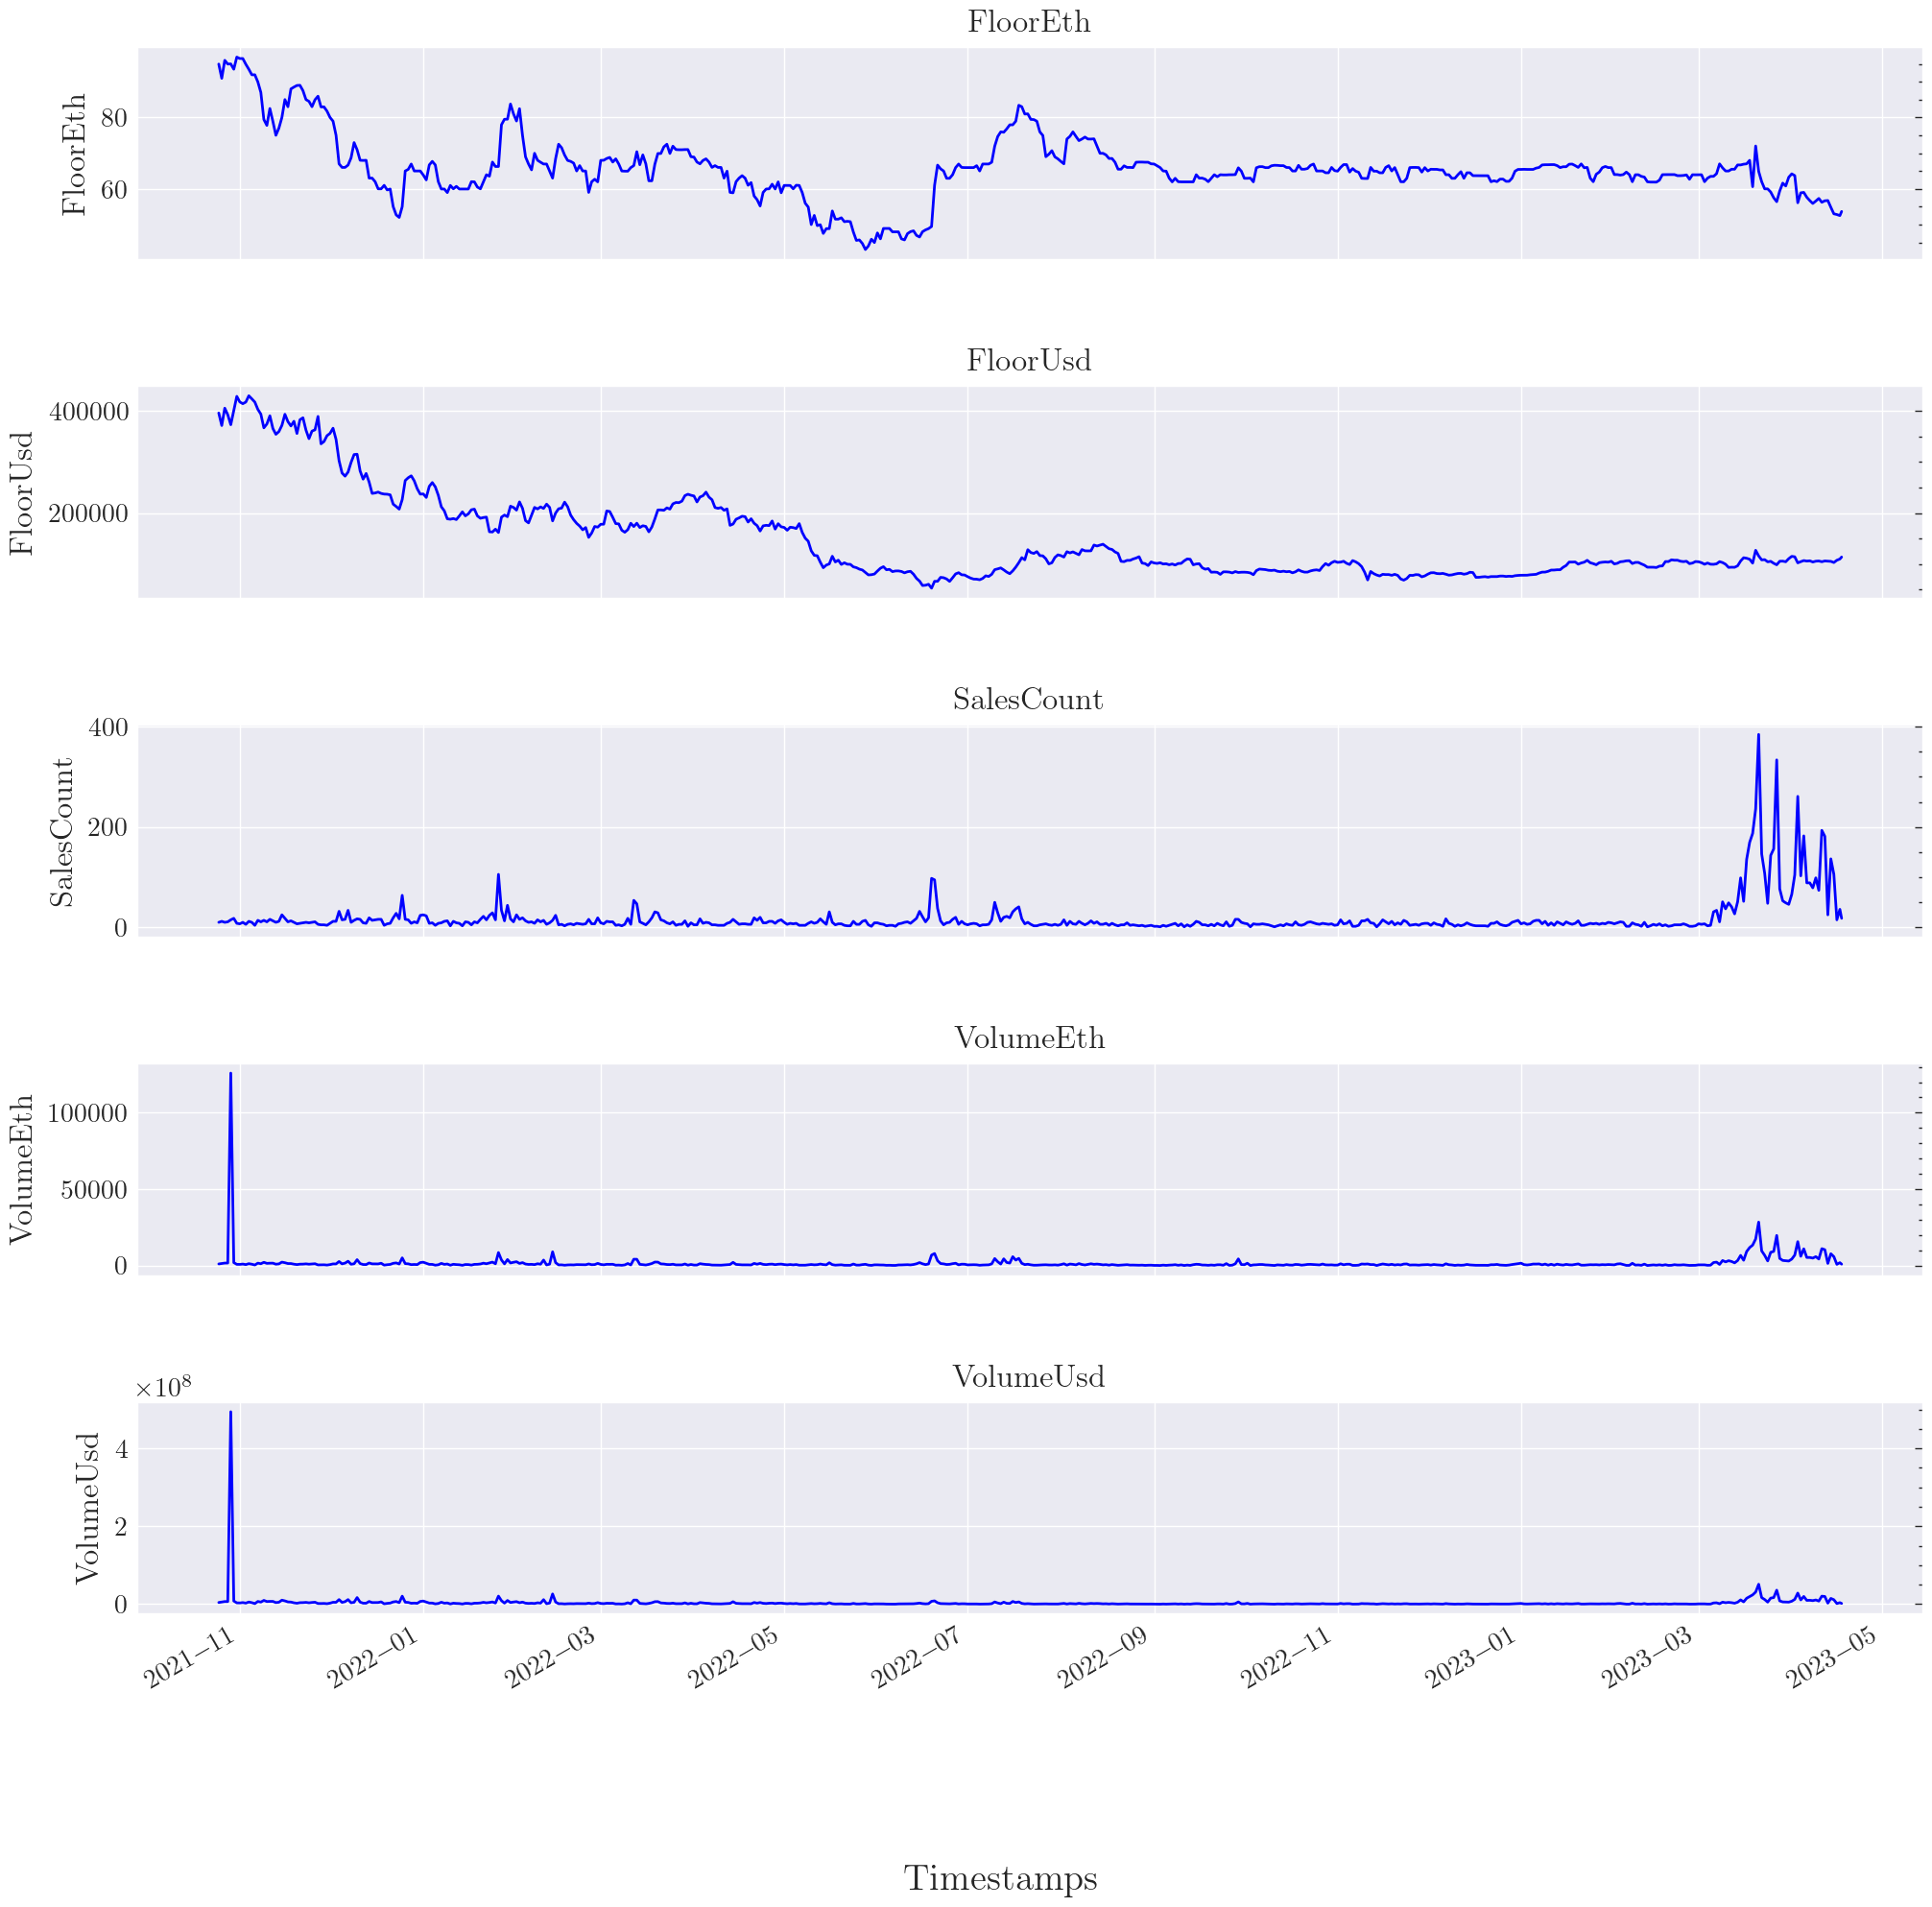

In [154]:
# Set the figure size and dpi
fig = plt.figure(figsize=(12, 12), dpi=200)

# Set the title of the figure
# fig.suptitle('Time Series Analysis of Fluf-World Project', fontsize=18, fontweight='bold')

# Create a grid of subplots
grid = plt.GridSpec(5, 1, wspace=0.4, hspace=0.6)

# Load the time series data from a JSON file
slug = 'cryptopunks'
time_series_path = os.path.join(raw_data_path, slug, 'time_series.json')

with open(time_series_path, 'r') as f:
    time_series = json.load(f)
    time_series_df = pd.DataFrame(time_series)
    time_series_df['timestamps'] = pd.to_datetime(time_series_df['timestamps'] / 1000, unit='s')
    time_series_df = time_series_df.set_index('timestamps')

# Create subplots and plot the data
ax1 = fig.add_subplot(grid[0])
time_series_df.plot(ax=ax1, y='floorEth', title='FloorEth', legend=False, color='blue')
ax1.set_xlabel('')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax2 = fig.add_subplot(grid[1])
time_series_df.plot(ax=ax2, y='floorUsd', title='FloorUsd', legend=False, color='blue')
ax2.set_xlabel('')
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax3 = fig.add_subplot(grid[2])
time_series_df.plot(ax=ax3, y='salesCount', title='SalesCount', legend=False, color='blue')
ax3.set_xlabel('')
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax4 = fig.add_subplot(grid[3])
time_series_df.plot(ax=ax4, y='volumeEth', title='VolumeEth', legend=False, color='blue')
ax4.set_xlabel('')
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax5 = fig.add_subplot(grid[4])
time_series_df.plot(ax=ax5, y='volumeUsd', title='VolumeUsd', legend=False, color='blue')
ax5.set_xlabel('')
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)

# Add labels to the y-axes
ax1.set_ylabel('FloorEth', fontsize=12)
ax2.set_ylabel('FloorUsd', fontsize=12)
ax3.set_ylabel('SalesCount', fontsize=12)
ax4.set_ylabel('VolumeEth', fontsize=12)
ax5.set_ylabel('VolumeUsd', fontsize=12)

# Add a common x-axis label
fig.text(0.5, 0.08, 'Timestamps', ha='center', fontsize=14)

# Adjust the space between subplots
# plt.subplots_adjust(hspace=0.5)

# Show the plot

plt.savefig('time_series_analysis.png', dpi=200)

plt.show()